In [1]:
import plotly
import math
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from timeit import default_timer as timer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from pandas.io.json import json_normalize
import warnings
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

In [2]:
import pickle
with open('results.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
tours = pd.read_pickle('tournaments.pkl')

In [4]:
train_ids = []
for key, value in tours.items():
    if 'dateStart' in value and value['dateStart'][0:4] == '2019':
        train_ids.append(key)

In [5]:
test_ids = []
for key, value in tours.items():
    if 'dateStart' in value and value['dateStart'][0:4] == '2020':
        test_ids.append(key)

In [6]:
train = defaultdict(list)
test = defaultdict(list)
total = defaultdict(list)
for key, i in data.items(): #номер игры
    if key in train_ids:
        for j in i: # команды
            if 'mask' in j and j['mask'] is not None :
                train[key].append(j)
                total[key].append(j)
    if key in test_ids:
        for j in i: # команды
            if 'mask' in j and j['mask'] is not None :
                test[key].append(j)
                total[key].append(j)

In [7]:
cour = []
player_ids = defaultdict(list)
for key, value in train.items():
    teams = {}
    current = 0
    for team_members in value:
        for i in team_members:
            if i == 'teamMembers':
                if key in teams.keys():
                    teams[key] += 1
                    current  += 1
                else:
                    teams[key] = 1
                    current  += 1
    cour.append(current)
        
    

player_ids = []
for key, value in train.items():
    for team_members in value:
        for i in team_members:
    for i in value['teamMembers']:
        player_ids.append(i['player']['id'])
player_ids_games_amount = Counter(player_ids)

def split(word):
    return [char for char in word]
player_ids = []
player_game = defaultdict(list)
for key, value in train.items():
    for teams in value:
        for team in teams:
            if team == 'mask':
                result = teams[team]
            if team == 'teamMembers':
                for players in teams[team]:                
                    player_ids.append(players['player'])
                    player_game[key].append([players['player']['id'], result, len(result)])



In [8]:
player_ids = []
game_player = defaultdict(list)
player_game = defaultdict(list)
for key, value in train.items():
    for teams in value:
        for team in teams:
            if team == 'mask':
                result = teams[team]
            if team == 'position':
                position = teams[team]
            if team == 'teamMembers':
                for players in teams[team]:
                    player_ids.append([players['player']['id'], players['player']['surname'], players['player']['name'], players['rating']])
                    game_player[key].append([players['player']['id'], result,len(result), position, players['rating']])
                    player_game[players['player']['id']].append([key, result, len(result), position, players['rating']])


In [9]:
player_ids_test = []
game_player_test = defaultdict(list)
player_game_test = defaultdict(list)
for key, value in test.items():
    for teams in value:
        for team in teams:
            if team == 'mask':
                result = teams[team]
            if team == 'position':
                position = teams[team]
            if team == 'teamMembers':
                for players in teams[team]:
                    player_ids_test.append([players['player']['id'], players['player']['surname'], players['player']['name'], players['rating']])
                    game_player_test[key].append([players['player']['id'], result,len(result), position, players['rating']])
                    player_game_test[players['player']['id']].append([key, result, len(result), position, players['rating']])


In [10]:
player_ids_total = []
game_player_total = defaultdict(list)
player_game_total = defaultdict(list)
for key, value in total.items():
    for teams in value:
        for team in teams:
            if team == 'mask':
                result = teams[team]
            if team == 'position':
                position = teams[team]
            if team == 'teamMembers':
                for players in teams[team]:
                    player_ids_total.append([players['player']['id'], players['player']['surname'], players['player']['name'], players['rating']])
                    game_player_total[key].append([players['player']['id'], result,len(result), position, players['rating']])
                    player_game_total[players['player']['id']].append([key, result, len(result), position, players['rating']])




In [11]:
details = pd.DataFrame(player_ids)
details_test = pd.DataFrame(player_ids_test)
#details_total = pd.DataFrame(player_ids_total)

In [12]:
columns = ['id', 'surname', 'name', 'rating']
details.columns = columns
details_test.columns = columns

In [13]:
details = details.drop_duplicates(subset='id', keep='last')
details = details.sort_values(by=['id'])
details_test = details_test.drop_duplicates(subset='id', keep='last')
details_test = details_test.sort_values(by=['id'])

def predict(user_id):
    inf = player_game[user_id]
    counter = 0
    list_of_answers = []
    user_answer = 0
    for row in inf:
        for i, value in enumerate(row[1]):
            if value not in ["?", "X"]:
                counter += 1
                user_answer += int(value)
                list_of_answers.append(int(value))
    return user_answer/counter

In [14]:
def predict_1(user_id):
    inf = player_game[user_id]
    counter = 0
    list_of_answers = []
    user_answer = 0
    game_counter = 0
    for row in inf:
        game_counter +=1
        for i, value in enumerate(row[1]):
            if value not in ["?", "X"]:
                counter += 1
                user_answer += int(value)
                list_of_answers.append(int(value))
    return game_counter, row[3], user_answer/counter, list_of_answers, row[4]

In [15]:
def predict_2(user_id):
    inf = player_game_test[user_id]
    counter = 0
    list_of_answers = []
    user_answer = 0
    game_counter = 0
    for row in inf:
        game_counter +=1
        for i, value in enumerate(row[1]):
            if value not in ["?", "X"]:
                counter += 1
                user_answer += int(value)
                list_of_answers.append(int(value))
    return game_counter, row[3], user_answer/counter, list_of_answers, row[4]

In [16]:
def cases_user_x(user_id):
    x_y_labels = predict_1(user_id)
    y_train = np.array(x_y_labels[3]).reshape(-1,1)
    #x_games = np.full((len(y_train), 1), x_y_labels[0])
    #x_counter = np.full((len(y_train), 1), x_y_labels[1])
    #x_prod = np.full((len(y_train), 1), x_y_labels[2])
    x_train = np.full((len(y_train), 4), [x_y_labels[0],x_y_labels[1],x_y_labels[2], x_y_labels[4]])
    return x_train
def cases_user_y(user_id):
    x_y_labels = predict_1(user_id)
    y_train = np.array(x_y_labels[3]).reshape(-1,1)
    return y_train
##try only with probability of predicted values
def cases_user_x_1(user_id):
    x_y_labels = predict_1(user_id)
    y_train = np.mean(x_y_labels[3])
    #x_games = np.full((len(y_train), 1), x_y_labels[0])
    #x_counter = np.full((len(y_train), 1), x_y_labels[1])
    #x_prod = np.full((len(y_train), 1), x_y_labels[2])
    x_train = np.full((1, 4), [x_y_labels[0],x_y_labels[1],x_y_labels[2], x_y_labels[4]])
    return x_train
def cases_user_y_1(user_id):
    x_y_labels = predict_1(user_id)
    y_train = np.mean(x_y_labels[3])
    return y_train
def cases_user_x_2(user_id):
    x_y_labels = predict_2(user_id)
    y_train = np.mean(x_y_labels[3])
    #x_games = np.full((len(y_train), 1), x_y_labels[0])
    #x_counter = np.full((len(y_train), 1), x_y_labels[1])
    #x_prod = np.full((len(y_train), 1), x_y_labels[2])
    x_train = np.full((1, 4), [x_y_labels[0],x_y_labels[1],x_y_labels[2], x_y_labels[4]])
    return x_train
def cases_user_y_2(user_id):
    x_y_labels = predict_2(user_id)
    y_train = np.mean(x_y_labels[3])
    return y_train

In [ ]:
X = np.vstack(list(map(cases_user_x_1, details['id'].sort_values())))
y = np.vstack(list(map(cases_user_y_1, details['id'].sort_values())))

In [ ]:
X_test = np.vstack(list(map(cases_user_x_2, details_test['id'].sort_values())))
y_test = np.vstack(list(map(cases_user_y_2, details_test['id'].sort_values())))

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
scaler = StandardScaler()

In [ ]:
X_norm = scaler.fit_transform(X)
X_norm_test = scaler.fit_transform(X_test)

In [ ]:
start = timer()
model = LinearRegression()
y = np.clip(y, 1e-8, 1 - 1e-8)
inv_sig_y = np.log(y / (1 - y))  
model.fit(X_norm, inv_sig_y)
end = timer()
print(end - start)

In [ ]:
def sigmoid(x):
    ex = np.exp(x)
    return ex / (1 + ex)

preds = sigmoid(model.predict(X_norm_test))

In [ ]:
print (preds.shape)

In [ ]:
y_test.shape

In [ ]:
diff = y_test - preds


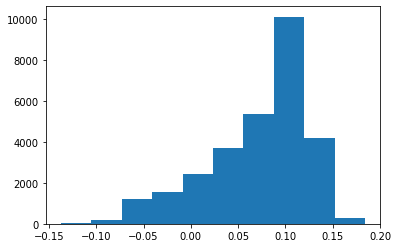

In [37]:
diff
plt.hist(diff)
plt.show()

In [60]:
final = details_test.sort_values(['res'], ascending = False)
final.head(10)

,id,surname,name,rating,res
21619,36844,Щербина,Павел,855,0.951208
21625,51717,Джапаров,Ержан,2761,0.937103
21618,76264,Иваницкий,Илья,8125,0.934724
9513,224660,Байдуков,Валентин,0,0.932786
6696,108228,Резонтова,Наталья,286,0.932046
45348,32585,Улахович,Владимир,7590,0.923893
106480,73090,Третьяков,Кирилл,4675,0.919330
86969,169948,Павлов,Степан,75,0.915689
97218,201697,Бардин,Александр,1530,0.915094
4107,184250,Гудзь,Анна,1822,0.914087


2 method

In [25]:
vocab = {}

for key, value in player_game_total.items():
    count = 0
    for i in value:
        count += 1
    vocab[key] = count

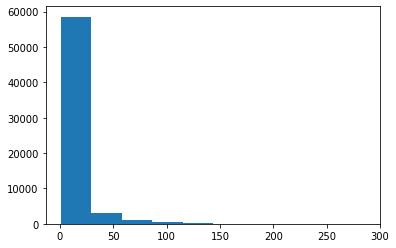

In [26]:
plt.hist(vocab.values(), bins=10)
plt.show()

In [27]:
d = dict((k, v) for k, v in vocab.items() if v >= 10)

In [28]:
vocab = d

In [29]:
len(vocab)

13178

In [30]:
cour = {}
player_ids = defaultdict(list)
for key, value in train.items():
    teams = {}
    current = 0
    for team_members in value:
        for i in team_members:
            if i == 'teamMembers':
                if key in teams.keys():
                    teams[key] += 1
                    current  += 1
                else:
                    teams[key] = 1
                    current  += 1
    cour[key] = current
        

In [31]:
def games_to_user(game):
    start = timer()
    team_amount = cour[game]
    inf = train[game]
    game_rows = np.full((team_amount, len(vocab)), np.zeros(len(vocab)))
    row_counter = 0
    for teams in inf:
        for team in teams:
            if team == 'teamMembers':
                for players in teams[team]:
                    if players['player']['id'] in vocab.keys():
                        game_rows[row_counter][vocab[players['player']['id']]] += 1
        row_counter += 1
    end = timer()
    return game_rows

In [48]:
total_game_mask = defaultdict(list)
for key, i in data.items(): #номер игры
    if key in train_ids:
        for j in i: # команды
            if 'mask' in j and j['mask'] is not None :
                total_game_mask[key].append(j['mask'])
    #if key in test_ids:
    #    for j in i: # команды
    #        if 'mask' in j and j['mask'] is not None :
    #            total_game_mask[key].append(j['mask'])

In [33]:
def pred(game):
    inf = total_game_mask[game]
    game_rows = np.full((len(inf), 1), 0.0)
    counter = 0
    for row in inf:
        sum_list_of_answers = 0.0
        count = 0.0
        for value in row:
            if value not in ["?", "X"]:
                sum_list_of_answers += int(value)
                count += 1
        game_rows[counter] = sum_list_of_answers / count
        counter += 1
    return game_rows

In [34]:
X_train_user = np.vstack(list(map(games_to_user, train.keys())))

In [35]:
y_train_user = np.vstack(list(map(pred, train.keys())))

In [36]:
start = timer()
model = LinearRegression()
y_train_user = np.clip(y_train_user, 1e-8, 1 - 1e-8)
inv_sig_y = np.log(y_train_user / (1 - y_train_user))  
model.fit(X_train_user, inv_sig_y)
end = timer()
print(end - start)

1344.55299408


In [37]:
def sigmoid(x):
    ex = np.exp(x)
    return ex / (1 + ex)

preds = sigmoid(model.predict(X_train_user))

In [38]:
diff = y_train_user - preds

In [58]:
res = model.coef_.reshape(-1, 1)

In [41]:
total = {}
for i, j in enumerate(vocab.keys()):
    total[j] = res[i]

In [44]:
for_pd = dict(Counter(total).most_common(10))

In [45]:
details[details['id'].isin(for_pd.keys())].sort_values(by='rating', ascending = False)

,id,surname,name,rating
439913,18332,Либер,Александр,14464
447681,1585,Архангельская,Юлия,13618
428107,15456,Коновалов,Сергей,13572
423332,18036,Левандовский,Михаил,13351
439818,12313,Иванченко,Сергей,13274
420715,26089,Прокофьева,Ирина,12877
445127,12747,Исраэлит,Валентин,12815
445128,31190,Тальянский,Илья,12768
447585,96642,Макагонов,Алексей,11479
440100,17230,Куликов,Егор,10655


In [52]:
cour_test = {}
player_ids = defaultdict(list)
for key, value in test.items():
    teams = {}
    current = 0
    for team_members in value:
        for i in team_members:
            if i == 'teamMembers':
                if key in teams.keys():
                    teams[key] += 1
                    current  += 1
                else:
                    teams[key] = 1
                    current  += 1
    cour_test[key] = current
def games_to_user(game):
    start = timer()
    team_amount = cour_test[game]
    inf = test[game]
    game_rows = np.full((team_amount, len(vocab)), np.zeros(len(vocab)))
    row_counter = 0
    for teams in inf:
        for team in teams:
            if team == 'teamMembers':
                for players in teams[team]:
                    if players['player']['id'] in vocab.keys():
                        game_rows[row_counter][vocab[players['player']['id']]] += 1
        row_counter += 1
    end = timer()
    return game_rows
total_game_mask = defaultdict(list)
for key, i in data.items(): #номер игры
    #if key in train_ids:
    #    for j in i: # команды
    #        if 'mask' in j and j['mask'] is not None :
    #            total_game_mask[key].append(j['mask'])
    if key in test_ids:
        for j in i: # команды
            if 'mask' in j and j['mask'] is not None :
                total_game_mask[key].append(j['mask'])

In [51]:
X_test_user = np.vstack(list(map(games_to_user, test.keys())))

In [54]:
y_test_user = np.vstack(list(map(pred, test.keys())))

In [55]:
preds = sigmoid(model.predict(X_test_user))

In [56]:
vocab_test = {}

for key, value in player_game_test.items():
    count = 0
    for i in value:
        count += 1
    vocab_test[key] = count

In [62]:
d = dict((k, v) for k, v in vocab_test.items() if v >= 10)

In [63]:
vocab_test = d

In [64]:
total = {}
for i, j in enumerate(vocab_test.keys()):
    total[j] = res[i]

In [65]:
for_pd = dict(Counter(total).most_common(10))

In [66]:
details[details['id'].isin(for_pd.keys())].sort_values(by='rating', ascending = False)

,id,surname,name,rating
443608,30270,Спешков,Сергей,14560
443606,27822,Савченков,Михаил,14514
425646,27403,Руссо,Максим,14440
448012,4270,Брутер,Александра,13615
448083,34936,Чернышёв,Кирилл,13610
445456,89287,Середа,Алексей,12131
445591,39596,Лавренов,Александр,12126
440522,43356,Васильченко,Сергей,11857
417574,40390,Гордынец,Елена,10508
447024,148884,Скотт,Таня,8366


In [19]:
a = 0
for i in game_player.values():
    a += len(i)
print (a)

451783


In [21]:
len(test_ids)

418

In [37]:
X_train = np.stack(list(map(predict, details['id'].sort_values())))

In [38]:
details['probability'] = X_train

In [39]:
details.head(1000)

,id,surname,name,rating,probability
423138,15,Абарников,Олег,7841,0.360714
404455,16,Абасалиев,Азер,3301,0.551282
3763,23,Абащенко,Андрей,791,0.500000
443177,31,Абасова,Ситара,5752,0.444444
444079,35,Абгарян,Нарек,6717,0.520607
...,...,...,...,...,...
274000,7002,Гиззатуллин,Рафаэль,0,0.556025
448063,7006,Гиззатуллина,Гульнара,9841,0.520579
439909,7008,Гилёв,Алексей,13998,0.745618
45630,7014,Гиленко,Дмитрий,0,0.457143


In [ ]:
vocab = {}
count = 0
for key, value in game_player.items():
    max_ln = 0
    for i in value:
        max_ln = max(max_ln, i[2])
    for ind in range(0, max_ln):
        vocab[str(key) + " " + str(ind)] = count
        count += 1
print (count)

In [ ]:
def user_to_bow(user_id):
    start = timer()
    user_row = np.zeros(len(vocab))
    inf = player_game[user_id]
    for row in inf:
        for i, value in enumerate(row[1]):
            if value not in ["?", "X"]:
                #print (i, value, len(row[1]), user_id, row[0])
                user_row[vocab[str(row[0]) + " " + str(i)]] += int(value)
    end = timer()
    #print(end - start)
    return user_row

In [575]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59101 entries, 56 to 451782
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       59101 non-null  int64 
 1   surname  59101 non-null  object
 2   name     59101 non-null  object
 3   rating   59101 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [579]:
y_train = total['rating'].values

In [581]:
X_train_tt, X_test_tt, y_train_val, y_test_val = train_test_split(
X_train, y_train, test_size=0.33, random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(X_train_tt, y_train_val)

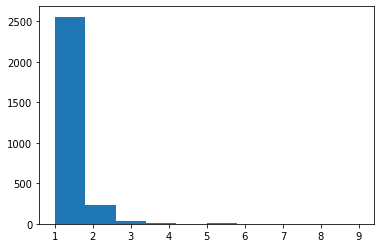

In [82]:
plt.hist(player_ids_games_amount.values())
plt.show()

train = defaultdict(list)
test = defaultdict(list)
for key, i in data.items(): #номер игры
    if key == a:
        print ('heu')
        for j in i: # команды
            print (j)
            if 'mask' in j:
                train[key].append(j)